In [2]:
# ECG Heart Risk Classification Model Comparison
# Import necessary libraries
from google.colab import drive
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten, Dense, Dropout,
                                     Input, GlobalAveragePooling2D, BatchNormalization)
from tensorflow.keras.applications import ResNet50, MobileNetV2

In [3]:
# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Load data from Google Drive
data_path = '/content/drive/MyDrive/ECG_IMAGES_DATASET'
print("Files and folders in", data_path, ":\n")
print(os.listdir(data_path))


Files and folders in /content/drive/MyDrive/ECG_IMAGES_DATASET :

['.DS_Store', 'ECG Images of Patient that have History of MI (172x12=2064)', 'ECG Images of Myocardial Infarction Patients (240x12=2880)', 'ECG Images of Patient that have abnormal heartbeat (233x12=2796)', 'Normal Person ECG Images (284x12=3408)']


In [5]:
# Prepare empty lists for images and labels
images = []
labels = []


In [6]:

# Get class folders (ignore hidden files)
class_names = [cls for cls in os.listdir(data_path) if not cls.startswith('.')]
class_to_label = {class_name: idx for idx, class_name in enumerate(class_names)}
print("Class to Label mapping:", class_to_label)

Class to Label mapping: {'ECG Images of Patient that have History of MI (172x12=2064)': 0, 'ECG Images of Myocardial Infarction Patients (240x12=2880)': 1, 'ECG Images of Patient that have abnormal heartbeat (233x12=2796)': 2, 'Normal Person ECG Images (284x12=3408)': 3}


In [7]:
# Image size used in your notebook
IMG_WIDTH, IMG_HEIGHT = 224, 224

In [8]:

# Load images and labels
for class_name in class_names:
    class_folder = os.path.join(data_path, class_name)
    for image_file in os.listdir(class_folder):
        if image_file.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(class_folder, image_file)
            # Load image with target size
            img = load_img(img_path, target_size=(IMG_WIDTH, IMG_HEIGHT))
            # Convert to numpy array and normalize
            img_array = img_to_array(img) / 255.0
            images.append(img_array)
            labels.append(class_to_label[class_name])

In [9]:
# Convert to numpy arrays
images = np.array(images)
labels = np.array(labels)
print(f"Loaded {len(images)} images with shape {images[0].shape}")
print(f"Labels shape: {labels.shape}")

Loaded 928 images with shape (224, 224, 3)
Labels shape: (928,)


In [10]:
# Split data into train and test sets
# Split data into train (80%) and test (20%)
X_train, X_test, y_train, y_test = train_test_split(
    images, labels, test_size=0.2, random_state=42, stratify=labels
)
print("Training data shape:", X_train.shape, y_train.shape)
print("Testing data shape:", X_test.shape, y_test.shape)

Training data shape: (742, 224, 224, 3) (742,)
Testing data shape: (186, 224, 224, 3) (186,)


In [11]:
# Convert labels to one-hot encoding
y_train_cat = to_categorical(y_train, num_classes=4)
y_test_cat = to_categorical(y_test, num_classes=4)
print("One-hot encoded training labels shape:", y_train_cat.shape)
print("One-hot encoded testing labels shape:", y_test_cat.shape)

One-hot encoded training labels shape: (742, 4)
One-hot encoded testing labels shape: (186, 4)


In [12]:
# Model 1: Sequential CNN Model (Original model)
def create_sequential_model():
    model = Sequential()
    # First Conv Layer
    model.add(Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)))
    model.add(MaxPooling2D(pool_size=(2,2)))
    # Second Conv Layer
    model.add(Conv2D(64, (3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    # Flatten and Dense layers
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    # Output layer for 4 classes
    model.add(Dense(4, activation='softmax'))

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [13]:
# Model 2: Functional API CNN with more layers and BatchNormalization
def create_functional_cnn():
    inputs = Input(shape=(224, 224, 3))

    # First convolutional block
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Second convolutional block
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Third convolutional block
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Fully connected layers
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # Output layer
    outputs = Dense(4, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [14]:
# Model 3: Transfer Learning with MobileNetV2
def create_transfer_learning_model():
    # Use MobileNetV2 as base model (smaller than ResNet50)
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freeze the base model
    base_model.trainable = False

    # Add custom layers
    inputs = Input(shape=(224, 224, 3))
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(4, activation='softmax')(x)

    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [15]:
# Create the three models
sequential_model = create_sequential_model()
functional_model = create_functional_cnn()
transfer_model = create_transfer_learning_model()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [16]:
# Display model summaries
print("Sequential Model Summary:")
sequential_model.summary()

print("\nFunctional CNN Model Summary:")
functional_model.summary()

print("\nTransfer Learning Model Summary:")
transfer_model.summary()

Sequential Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 186624)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    23,888,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,907,908 (91.20 MB)

 Trainable params: 23,907,908 (91.20 MB)

 Non-trainable params: 0 (0.00 B)


Functional CNN Model Summary:


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │    25,690,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 26,014,116 (99.24 MB)

 Trainable params: 26,012,452 (99.23 MB)

 Non-trainable params: 1,664 (6.50 KB)


Transfer Learning Model Summary:


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,468 (9.24 MB)

 Trainable params: 164,484 (642.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [17]:
# Train models
epochs = 15
batch_size = 32

In [18]:
# Train Sequential Model
print("\nTraining Sequential Model...")
sequential_history = sequential_model.fit(
    X_train, y_train_cat,
    validation_data=(X_test, y_test_cat),
    epochs=epochs,
    batch_size=batch_size
)


Training Sequential Model...
Epoch 1/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 14s 274ms/step - accuracy: 0.2656 - loss: 12.9527 - val_accuracy: 0.2527 - val_loss: 1.3783
Epoch 2/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.3495 - loss: 1.3719 - val_accuracy: 0.3065 - val_loss: 1.3412
Epoch 3/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.3881 - loss: 1.3394 - val_accuracy: 0.4462 - val_loss: 1.3023
Epoch 4/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.4645 - loss: 1.2930 - val_accuracy: 0.5000 - val_loss: 1.1643
Epoch 5/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.5671 - loss: 1.0708 - val_accuracy: 0.8065 - val_loss: 0.7607
Epoch 6/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.7650 - loss: 0.7285 - val_accuracy: 0.8817 - val_loss: 0.4984
Epoch 7/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.8328 - loss: 0.5267 - val_accuracy: 0.9086 - val_loss: 0.3850
Epoch 8/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.8876 - loss: 

In [19]:
# Train Functional Model
print("\nTraining Functional CNN Model...")
functional_history = functional_model.fit(
    X_train, y_train_cat,
    validation_data=(X_test, y_test_cat),
    epochs=epochs,
    batch_size=batch_size
)


Training Functional CNN Model...
Epoch 1/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 43s 902ms/step - accuracy: 0.4792 - loss: 1.4330 - val_accuracy: 0.3065 - val_loss: 6.8225
Epoch 2/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 150ms/step - accuracy: 0.7959 - loss: 0.5902 - val_accuracy: 0.3065 - val_loss: 9.5323
Epoch 3/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - accuracy: 0.8863 - loss: 0.3264 - val_accuracy: 0.3065 - val_loss: 16.8964
Epoch 4/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - accuracy: 0.9036 - loss: 0.2375 - val_accuracy: 0.3065 - val_loss: 22.2253
Epoch 5/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - accuracy: 0.9533 - loss: 0.1694 - val_accuracy: 0.3065 - val_loss: 18.7268
Epoch 6/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - accuracy: 0.9460 - loss: 0.1663 - val_accuracy: 0.3065 - val_loss: 22.8543
Epoch 7/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 150ms/step - accuracy: 0.9610 - loss: 0.1449 - val_accuracy: 0.3065 - val_loss: 22.7682
Epoch 8/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - accuracy: 

In [20]:
# Train Transfer Learning Model
print("\nTraining Transfer Learning Model...")
transfer_history = transfer_model.fit(
    X_train, y_train_cat,
    validation_data=(X_test, y_test_cat),
    epochs=epochs,
    batch_size=batch_size
)


Training Transfer Learning Model...
Epoch 1/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 28s 730ms/step - accuracy: 0.2768 - loss: 1.6354 - val_accuracy: 0.5269 - val_loss: 1.1829
Epoch 2/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 20s 48ms/step - accuracy: 0.4723 - loss: 1.2022 - val_accuracy: 0.5538 - val_loss: 1.0981
Epoch 3/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.4906 - loss: 1.1429 - val_accuracy: 0.6398 - val_loss: 0.9931
Epoch 4/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.5853 - loss: 1.0332 - val_accuracy: 0.6290 - val_loss: 0.9305
Epoch 5/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.5853 - loss: 0.9638 - val_accuracy: 0.6183 - val_loss: 0.9164
Epoch 6/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.6110 - loss: 0.9205 - val_accuracy: 0.6559 - val_loss: 0.8579
Epoch 7/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.6633 - loss: 0.8850 - val_accuracy: 0.6613 - val_loss: 0.8417
Epoch 8/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.6479 -

In [21]:
# Evaluate models
# Function to evaluate model performance
def evaluate_model(model, model_name):
    # Evaluate on test data
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test_cat, axis=1)

    # Print classification report
    print(f"\n{model_name} - Classification Report:")
    print(classification_report(y_true, y_pred_classes))

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred_classes)
    return cm

In [22]:
# Evaluate each model
sequential_cm = evaluate_model(sequential_model, "Sequential Model")
functional_cm = evaluate_model(functional_model, "Functional CNN Model")
transfer_cm = evaluate_model(transfer_model, "Transfer Learning Model")

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step

Sequential Model - Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.94      0.93        34
           1       1.00      1.00      1.00        48
           2       0.95      0.89      0.92        47
           3       0.93      0.96      0.95        57

    accuracy                           0.95       186
   macro avg       0.95      0.95      0.95       186
weighted avg       0.95      0.95      0.95       186

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 188ms/step

Functional CNN Model - Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        34
           1       0.00      0.00      0.00        48
           2       0.00      0.00      0.00        47
           3       0.31      1.00      0.47        57

    accuracy                           0.31       186
   macro avg       0.08      0.25      0.12       186
weighted avg      

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 976ms/step

Transfer Learning Model - Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.03      0.06        34
           1       0.77      0.92      0.84        48
           2       0.89      0.68      0.77        47
           3       0.58      0.93      0.71        57

    accuracy                           0.70       186
   macro avg       0.81      0.64      0.59       186
weighted avg       0.78      0.70      0.64       186



In [23]:
# Plot training history for all models
def plot_training_history():
    fig, axs = plt.subplots(2, 2, figsize=(20, 10))

    # Accuracy subplot
    axs[0, 0].plot(sequential_history.history['accuracy'], label='Sequential')
    axs[0, 0].plot(functional_history.history['accuracy'], label='Functional CNN')
    axs[0, 0].plot(transfer_history.history['accuracy'], label='Transfer Learning')
    axs[0, 0].set_title('Training Accuracy')
    axs[0, 0].set_xlabel('Epoch')
    axs[0, 0].set_ylabel('Accuracy')
    axs[0, 0].legend()

    # Validation accuracy subplot
    axs[0, 1].plot(sequential_history.history['val_accuracy'], label='Sequential')
    axs[0, 1].plot(functional_history.history['val_accuracy'], label='Functional CNN')
    axs[0, 1].plot(transfer_history.history['val_accuracy'], label='Transfer Learning')
    axs[0, 1].set_title('Validation Accuracy')
    axs[0, 1].set_xlabel('Epoch')
    axs[0, 1].set_ylabel('Accuracy')
    axs[0, 1].legend()

    # Loss subplot
    axs[1, 0].plot(sequential_history.history['loss'], label='Sequential')
    axs[1, 0].plot(functional_history.history['loss'], label='Functional CNN')
    axs[1, 0].plot(transfer_history.history['loss'], label='Transfer Learning')
    axs[1, 0].set_title('Training Loss')
    axs[1, 0].set_xlabel('Epoch')
    axs[1, 0].set_ylabel('Loss')
    axs[1, 0].legend()

    # Validation loss subplot
    axs[1, 1].plot(sequential_history.history['val_loss'], label='Sequential')
    axs[1, 1].plot(functional_history.history['val_loss'], label='Functional CNN')
    axs[1, 1].plot(transfer_history.history['val_loss'], label='Transfer Learning')
    axs[1, 1].set_title('Validation Loss')
    axs[1, 1].set_xlabel('Epoch')
    axs[1, 1].set_ylabel('Loss')
    axs[1, 1].legend()

    plt.tight_layout()
    plt.show()

In [24]:
# Plot confusion matrices
def plot_confusion_matrices():
    fig, axs = plt.subplots(1, 3, figsize=(20, 5))

    # Sequential model confusion matrix
    axs[0].imshow(sequential_cm, cmap='Blues')
    axs[0].set_title('Sequential Model')
    axs[0].set_xlabel('Predicted')
    axs[0].set_ylabel('True')

    # Functional model confusion matrix
    axs[1].imshow(functional_cm, cmap='Blues')
    axs[1].set_title('Functional CNN Model')
    axs[1].set_xlabel('Predicted')

    # Transfer learning model confusion matrix
    axs[2].imshow(transfer_cm, cmap='Blues')
    axs[2].set_title('Transfer Learning Model')
    axs[2].set_xlabel('Predicted')

    plt.tight_layout()
    plt.show()

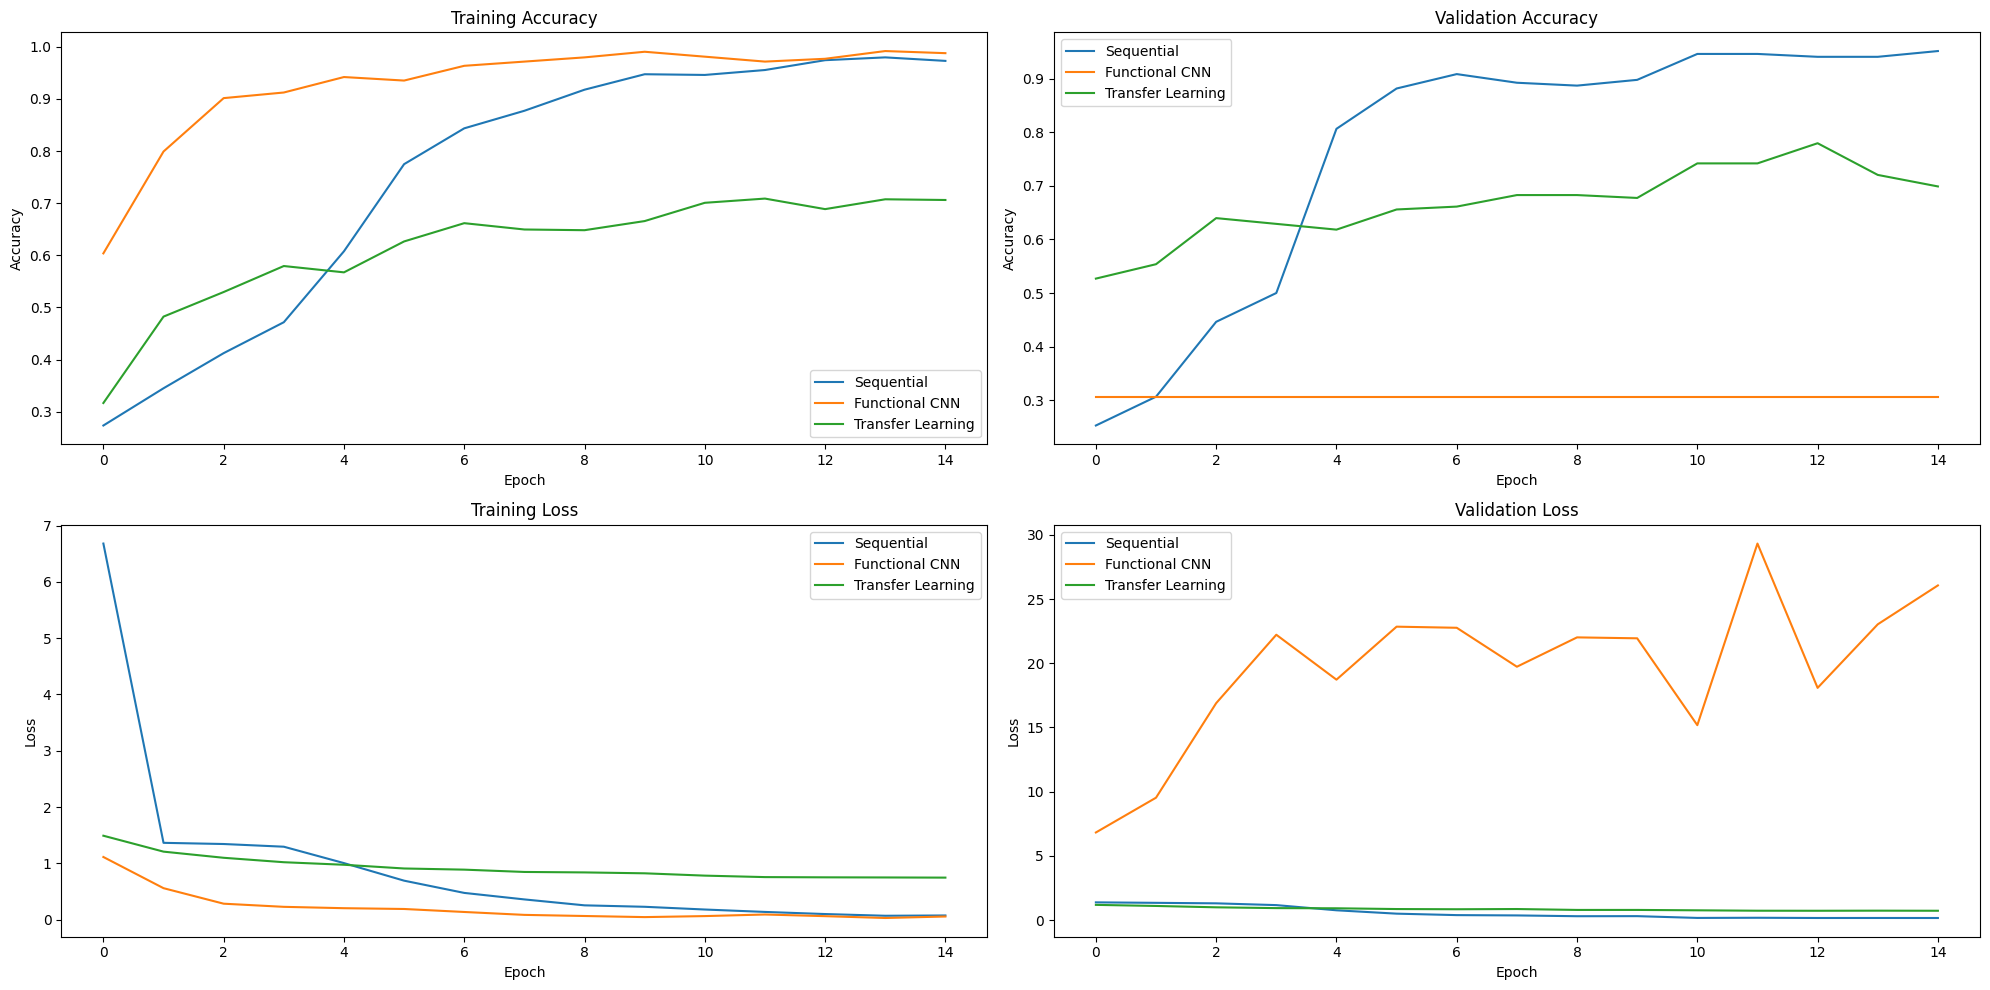

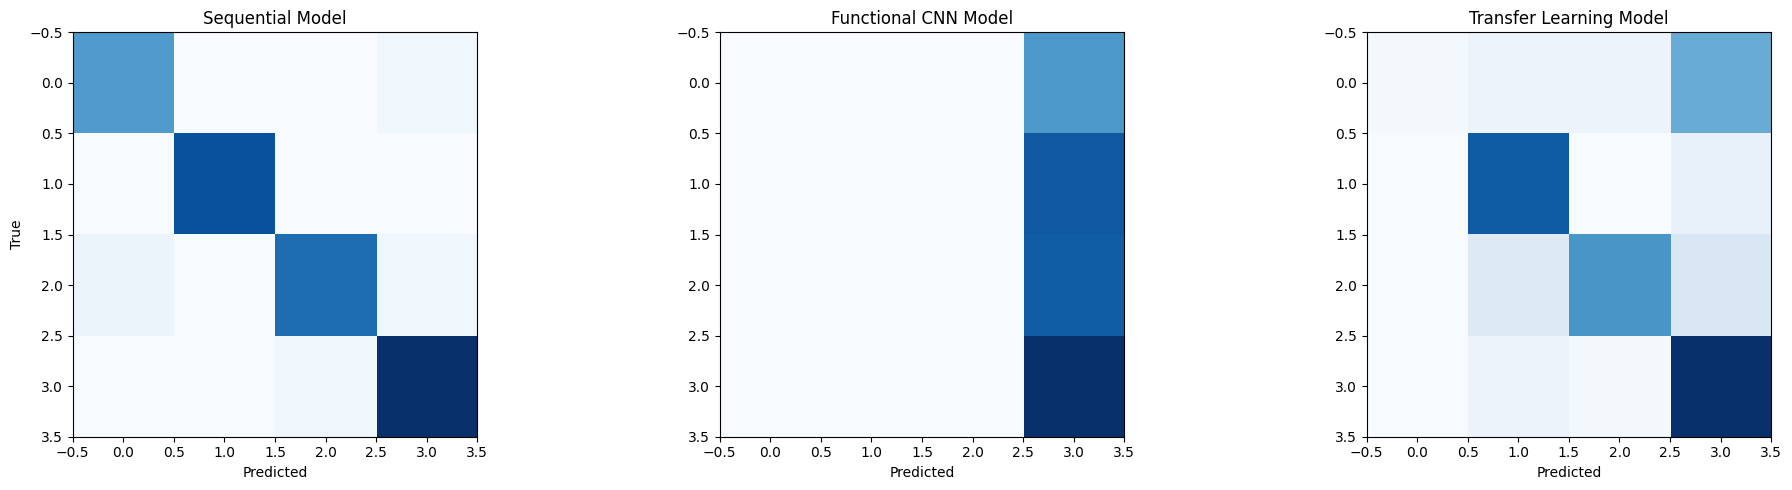

In [25]:
# Plot the results
plot_training_history()
plot_confusion_matrices()

In [26]:
# Save models
sequential_model.save('sequential_ecg_model.h5')
functional_model.save('functional_ecg_model.h5')
transfer_model.save('transfer_ecg_model.h5')

In [27]:
# Final comparison of model performance
final_sequential_loss, final_sequential_acc = sequential_model.evaluate(X_test, y_test_cat)
final_functional_loss, final_functional_acc = functional_model.evaluate(X_test, y_test_cat)
final_transfer_loss, final_transfer_acc = transfer_model.evaluate(X_test, y_test_cat)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9422 - loss: 0.1805
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.2798 - loss: 27.1469
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.7015 - loss: 0.7245


In [28]:
print("\n===== Final Model Comparison =====")
print(f"Sequential Model: Accuracy = {final_sequential_acc:.4f}, Loss = {final_sequential_loss:.4f}")
print(f"Functional CNN: Accuracy = {final_functional_acc:.4f}, Loss = {final_functional_loss:.4f}")
print(f"Transfer Learning: Accuracy = {final_transfer_acc:.4f}, Loss = {final_transfer_loss:.4f}")


===== Final Model Comparison =====
Sequential Model: Accuracy = 0.9516, Loss = 0.1602
Functional CNN: Accuracy = 0.3065, Loss = 26.0672
Transfer Learning: Accuracy = 0.6989, Loss = 0.7250


In [29]:
sequential_model.save('sequential_ecg_model.h5')
